In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from skimage import io, transform
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
%matplotlib inline


matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#/kaggle/input/sorghum-id-fgvc-9/sample_submission.csv
#train_cultivar_mapping.csv
#/kaggle/input/sorghum-id-fgvc-9/train_images/
#/kaggle/input/sorghum-id-fgvc-9/test/

In [2]:
data_dir = '/kaggle/input/sorghum-id-fgvc-9'

In [3]:
os.listdir(data_dir)

['sample_submission.csv', 'train_cultivar_mapping.csv', 'train_images', 'test']

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = PIL.Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
dr_dir = pd.read_csv("/kaggle/input/sorghum-id-fgvc-9/train_cultivar_mapping.csv")

In [6]:
file_list = []
for dirname, _, filenames in os.walk("/kaggle/input/sorghum-id-fgvc-9/train_images/"):
    file_list.append(filenames)


In [7]:
file_list = file_list[0]

In [8]:
file_list = [i.replace('"', '') for i in file_list]

In [9]:
dr_dir["image"]

0        2017-06-21__11-32-09-227.png
1        2017-06-27__10-36-57-694.png
2        2017-06-13__12-10-43-125.png
3        2017-06-03__12-37-57-818.png
4        2017-06-03__12-37-24-028.png
                     ...             
22630    2017-06-04__13-32-11-825.png
22631    2017-06-04__13-33-43-417.png
22632    2017-06-20__12-19-56-066.png
22633    2017-06-09__12-51-11-655.png
22634    2017-06-13__12-02-12-842.png
Name: image, Length: 22635, dtype: object

In [10]:
dr_dir

,image,cultivar
0,2017-06-21__11-32-09-227.png,PI_152923
1,2017-06-27__10-36-57-694.png,PI_152923
2,2017-06-13__12-10-43-125.png,PI_152923
3,2017-06-03__12-37-57-818.png,PI_152923
4,2017-06-03__12-37-24-028.png,PI_152923
...,...,...
22630,2017-06-04__13-32-11-825.png,PI_152967
22631,2017-06-04__13-33-43-417.png,PI_152967
22632,2017-06-20__12-19-56-066.png,PI_152967
22633,2017-06-09__12-51-11-655.png,PI_152967


In [11]:
dr_dir = dr_dir[dr_dir["image"].isin(file_list)]

In [12]:
rng = range(0,dr_dir["cultivar"].nunique())

In [13]:
dr_class = pd.DataFrame({"class":dr_dir["cultivar"].unique().tolist(),"int_class":rng})

In [14]:
dr_dir.head()

,image,cultivar
0,2017-06-21__11-32-09-227.png,PI_152923
1,2017-06-27__10-36-57-694.png,PI_152923
2,2017-06-13__12-10-43-125.png,PI_152923
3,2017-06-03__12-37-57-818.png,PI_152923
4,2017-06-03__12-37-24-028.png,PI_152923


In [15]:
dr_dir = pd.merge(dr_dir,dr_class, left_on= "cultivar",right_on = "class")

In [16]:
dr_dir = dr_dir.drop("class",axis= 1 )

In [17]:
dr_dir.dtypes

image        object
cultivar     object
int_class     int64
dtype: object

In [18]:
dr_dir.columns

Index(['image', 'cultivar', 'int_class'], dtype='object')

In [19]:
dr_dir[["image","int_class"]].to_csv("/kaggle/working/out.csv",index=False)
dr_dir.to_csv("/kaggle/working/full.csv",index=False)

In [20]:
dataset = CustomImageDataset("/kaggle/working/out.csv", "/kaggle/input/sorghum-id-fgvc-9/train_images/",transform=transforms.Compose([
                                               transforms.Resize((32,32)),
                                               ToTensor()]))

In [21]:
batch_size = 256
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


In [22]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dl = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [23]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [24]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

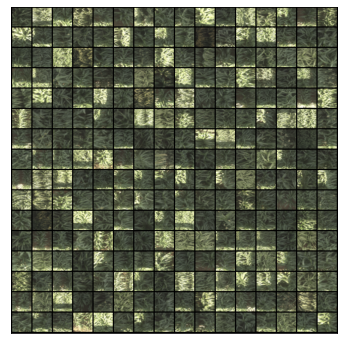

In [25]:
show_batch(train_dl)

In [26]:
train_features, train_labels = next(iter(train_dl))

Feature batch shape: torch.Size([256, 3, 32, 32])


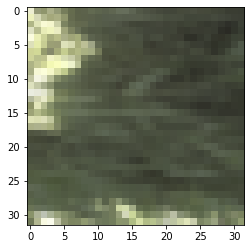

Label: 20


In [27]:
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze().permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
class SorghumCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100))
        
    def forward(self, xb):
        return self.network(xb)

In [30]:
model = SorghumCNN()
model

SorghumCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

In [31]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 100])
out[0]: tensor([ 0.0035, -0.0083, -0.0340,  0.0331, -0.0156, -0.0223,  0.0513,  0.0126,
         0.0387,  0.0267,  0.0053, -0.0246, -0.0079,  0.0058, -0.0337, -0.0194,
        -0.0402,  0.0446, -0.0260, -0.0226, -0.0359,  0.0540,  0.0037,  0.0022,
        -0.0439,  0.0263, -0.0152,  0.0395,  0.0065, -0.0191, -0.0229,  0.0030,
         0.0220,  0.0076,  0.0411,  0.0097, -0.0429, -0.0171, -0.0330, -0.0287,
         0.0233, -0.0155,  0.0196, -0.0371, -0.0072, -0.0005,  0.0114, -0.0028,
        -0.0076, -0.0084,  0.0026, -0.0155, -0.0166,  0.0486, -0.0302, -0.0395,
         0.0426, -0.0172,  0.0354, -0.0099, -0.0010, -0.0027, -0.0179, -0.0398,
        -0.0050, -0.0441,  0.0039, -0.0297,  0.0531, -0.0379, -0.0020, -0.0102,
         0.0015,  0.0402, -0.0131, -0.0320, -0.0075, -0.0272,  0.0286,  0.0387,
        -0.0362, -0.0099,  0.0059, -0.0004, -0.0033, -0.0370, -0.0332, -0.0207,
        -0.0252,  0.0266, -0.0411, 

In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
model = to_device(SorghumCNN(), device)

In [37]:
evaluate(model, val_dl)

{'val_loss': 4.605317115783691, 'val_acc': 0.007595486007630825}

In [38]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [1]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

NameError: name 'fit' is not defined

In [2]:
test_dataset = ImageFolder(data_dir+'/kaggle/input/sorghum-id-fgvc-9/test', transform=transforms.Compose([
                                               transforms.Resize((32,32)),
                                               ToTensor()]))

NameError: name 'ImageFolder' is not defined

In [3]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [4]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print(' Predicted:', predict_image(img, model))

NameError: name 'test_dataset' is not defined

In [ ]:
file_list = []
for dirname, _, filenames in os.walk("/kaggle/input/sorghum-id-fgvc-9/test/"):
    file_list.append(filenames)

file_list = [i.replace('"', '') for i in file_list]

In [5]:
file_list[0]

NameError: name 'file_list' is not defined

In [ ]:
Label = [predict_image(test_dataset[x], model) for x in range(0,len(test_dataset)) ] 
Imageid = [ x for x in file_list[0]] 

my_submission = pd.DataFrame({'filename': Imageid, 'cultivar': Label})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)